 # Example notebook for the QPE cirucit benchmark

 This notebook shows the basic workflow to perform the "calibration" in the paper.
 It shows how to specify the QEC set up described there.
 Note that it would take very long time if you chose `qec_level > 0` with the `H2-1LE` backend as specified below.
 The actual experiments were performed using [Quantinuum Nexus](https://nexus.quantinuum.com/signup).
 Further details are available up on request.

In [1]:
# Import the circuit renderer.
from pytket.circuit.display import render_circuit_jupyter

In [2]:
# Build the benchmarking (logical) circuits with QEC indicators.
from h2xh2.experiment import build_benchmark_circuits

# The number of Trotter steps.
k_list = [1, 2, 3, 4]

# QEC level.
qec_level = 0   # No Steane QEC gadgets.
# qec_level = 1   # Enable the Steane QEC for the X syndrome of the QPE ancilla qubit (referred to as Exp).
# qec_level = 2   # More Steane QEC gadgets (referred to as PFT).

# Partially FT Rz gates.
pft_rz = True if qec_level == 2 else False

# Now build the logical circuits.
logical_circuits = build_benchmark_circuits(
    k_list=k_list,
    pft_rz=pft_rz,
    qec_level=qec_level,
)

# Show the circuit.
render_circuit_jupyter(logical_circuits[1])

In [3]:
# Encode the logical circuit with the Steane code.
from h2xh2.encode import encode, EncodeOptions, RzMode, RzOptionsBinFracMeasFT


# Encode the circuit using the Steane code.
# Simplest encoding (non FT).
if qec_level == 0:
    encoded_circuits = [
        encode(
            circ,
            options=EncodeOptions(
                rz_mode=RzMode.DIRECT,
                ft_prep=False,
                ft_prep_synd=False,
            )
        ) for circ in logical_circuits
    ]
# Exp setup.
elif qec_level == 1:
    encoded_circuits = [
        encode(
            circ,
            options=EncodeOptions(
                rz_mode=RzMode.BIN_FRAC_MEAS_FT,
                rz_options=RzOptionsBinFracMeasFT(max_bits=5),
                ft_prep=False,
                ft_prep_synd=False,
            )
        ) for circ in logical_circuits
    ]
# PFT setup.
elif qec_level == 2:
    encoded_circuits = [
        encode(
            circ,
            options=EncodeOptions(
                rz_mode=RzMode.BIN_FRAC_PART_FT_GOTO,
                rz_options=RzOptionsBinFracPartFT(max_bits=5, n_rus=2),
                # FT state preparation.
                ft_prep=True,
                n_rus_prep=2,
                # FT state preparation for the Steane QEC gadget.
                ft_prep_synd=True,
                n_rus_synd=2,
            )
        ) for circ in logical_circuits
    ]
render_circuit_jupyter(encoded_circuits[1])

In [4]:
# Compile the encoded circuits.
from pytket.extensions.quantinuum import (
    QuantinuumBackend,
    QuantinuumAPIOffline,
)

backend = QuantinuumBackend(
    device_name="H2-1LE",
    api_handler=QuantinuumAPIOffline(),
)
compiled_circuits = backend.get_compiled_circuits(
    encoded_circuits,
    # Do not change the optimisation_level to be higher for QEC codes to avoid unexpected side effects.
    optimisation_level=0,
)

In [5]:
# Execute the compiled (encoded) circuits.
# NOTE: this could take very long time if you choose qec_level > 0. Consider using Quantinuum's backends on Nexus.

# N_SHOTS = 500      # Experimental setup in the paper.
N_SHOTS = 10       # For testing only.

encoded_results = backend.run_circuits(
    compiled_circuits,
    n_shots=N_SHOTS,
)

In [8]:
from h2xh2.encode import InterpretOptions, ReadoutMode, interpret

# Interpret the encoded results back in the logical space.
logical_results = [
    interpret(
        result,
        options=InterpretOptions(
            readout_mode=ReadoutMode.Correct,
            # readout_mode=steane.ReadoutMode.Detect,
            # readout_mode=steane.ReadoutMode.Raw,
        ),
    ) for result in encoded_results
]

In [9]:
# Calculate the probability to measure "0", which should be 100% for noiseless backends.
from h2xh2.experiment import process_benchmark_results

benchmark_results = process_benchmark_results(logical_results)

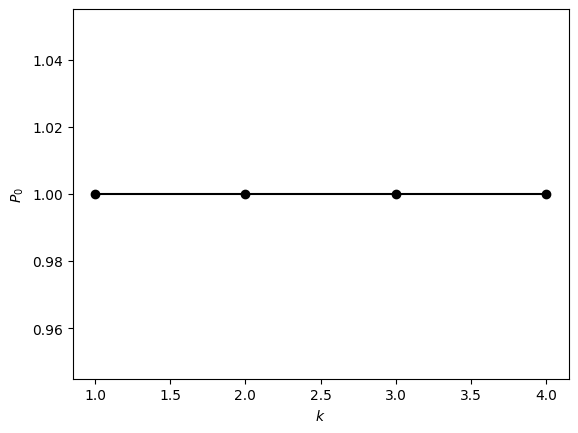

In [10]:
# Plot P_0, expecting exponential decay for noisy backends.
import matplotlib.pyplot as plt

plt.plot(k_list, benchmark_results.p0, "k-o")
plt.ylabel(r"$P_0$")
plt.xlabel(r"$k$");